In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt 

### Importing Versions

In [4]:
print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.18.0
2.0.2
2.2.3


### Constants

In [5]:
TRAIN_DIR = "D://animals-detection-images-dataset_//train"
TEST_DIR = "D://animals-detection-images-dataset_//test"
NUM_CLASSES = len(os.listdir(TRAIN_DIR))
IMAGE_SIZE = 600
BATCH_SIZE = 32
EPOCHS = 6
IMAGE_TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)

### Build the model

In [6]:
img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(
            height_factor=0.1,
            width_factor=0.1,
        ),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)



def build_model() -> "tf.keras.Model":
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = img_augmentation(inputs)

    model = tf.keras.applications.EfficientNetB7(
        include_top=False,
        input_tensor=x,
        weights="imagenet",
    )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(
        NUM_CLASSES,
        activation="softmax",
        name="pred",
    )(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


def unfreeze_model(model: "tf.keras.Model"):
    # unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

### Train the model

In [7]:
model = build_model()
unfreeze_model(model)

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,
)
train_batches = train_image_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_TARGET_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
)
valid_batches = train_image_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_TARGET_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
).flow_from_directory(
    directory=TEST_DIR,
    target_size=IMAGE_TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=valid_batches,
)

Found 195 images belonging to 3 classes.
Found 47 images belonging to 3 classes.
Found 151 images belonging to 3 classes.


c:\Users\diman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 373s 47s/step - accuracy: 0.4493 - loss: 1.4100 - val_accuracy: 0.8936 - val_loss: 0.7661
Epoch 2/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 313s 45s/step - accuracy: 0.7796 - loss: 0.5976 - val_accuracy: 0.9574 - val_loss: 0.6700
Epoch 3/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 311s 45s/step - accuracy: 0.8517 - loss: 0.3695 - val_accuracy: 0.9362 - val_loss: 0.6307
Epoch 4/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 310s 45s/step - accuracy: 0.8657 - loss: 0.3689 - val_accuracy: 0.9362 - val_loss: 0.6135
Epoch 5/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 311s 45s/step - accuracy: 0.8688 - loss: 0.3415 - val_accuracy: 0.9574 - val_loss: 0.6008
Epoch 6/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 311s 45s/step - accuracy: 0.9116 - loss: 0.3155 - val_accuracy: 0.9574 - val_loss: 0.5860


### Visualize the training results

In [8]:
epochs_range = range(EPOCHS)

training_acc = history.history["accuracy"]
validation_acc = history.history["val_accuracy"]
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
acc_df = pd.DataFrame(
    {"Training Accuracy": training_acc, "Validation Accuracy": validation_acc},
    index=epochs_range,
)
loss_df = pd.DataFrame(
    {"Training Loss": training_loss, "Validation Loss": validation_loss},
    index=epochs_range,
)

<Axes: >

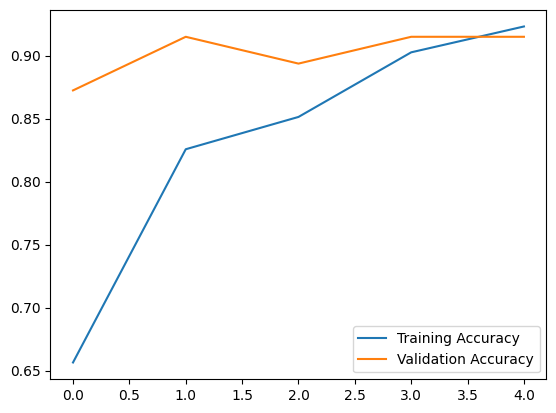

In [32]:
# Plot Accuracy
acc_df.plot()

<Axes: >

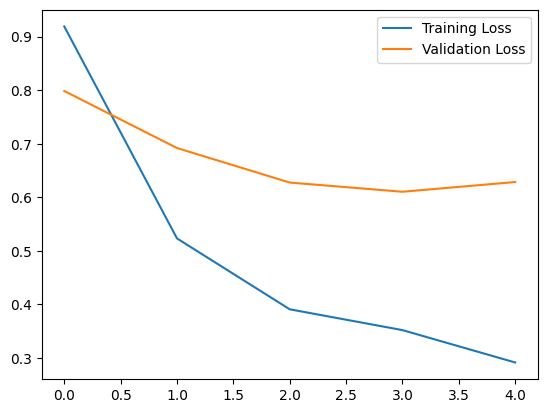

In [33]:
# Plot Loss
loss_df.plot()

### Test the model

In [9]:
test_labels = test_batches.classes
print("Test Labels", test_labels)
print(test_batches.class_indices)
predictions = model.predict(test_batches, steps=len(test_batches))
acc = 0
for i in range(len(test_labels)):
    actual_class = test_labels[i]
    if predictions[i][actual_class] > 0.5:
        acc += 1
print("Accuarcy:", (acc / len(test_labels)) * 100, "%")

Test Labels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]
{'Bear': 0, 'Brown bear': 1, 'Bull': 2}
5/5 ━━━━━━━━━━━━━━━━━━━━ 198s 38s/step
Accuarcy: 66.88741721854305 %


### Visualize test results

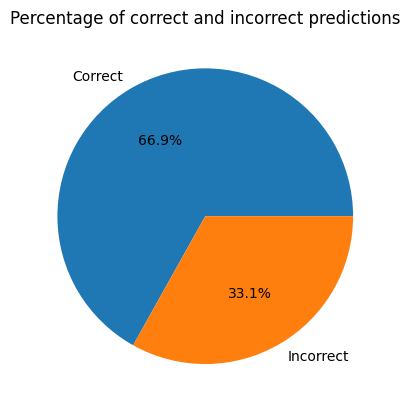

In [10]:
import matplotlib.pyplot as plt

values = [acc, len(test_labels) - acc]
labels = ['Correct', 'Incorrect']

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
ax.set_title('Percentage of correct and incorrect predictions')
plt.show()

### Save a model

In [15]:
# Save the entire model (architecture, weights, and optimizer state)
# model.save("animal_detection_model")
# Save only the weights of the model
# Пример изменения имени файла для сохранения весов модели
model.save_weights('D://animals-detection-images-dataset_//animal_detection_model.weights.h5')
model.save('D://animals-detection-images-dataset_//animal_detection_model.h5')
model.save('D://animals-detection-images-dataset_//animal_detection_model.keras')
   


   
